# $\textit{Detección de ondas gravitatorias}$
$\textit{Estimación Espectral No Paramétrica}$

In [8]:
#En ppio hay que elegir entre 32sec • 4KHz o 4096sec • 4KHz. Esto porque el evento esta alrededor de los 2Khz.
#Ademas, usamos el dataset de 4096 seg porque el ruido es localmente estacionario (hay que probarlo).

In [9]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
sns.set_theme()

In [11]:
# these 4096 second files are useful for computing more accurate psds
largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
fn_H1 = './Data/H-H1_' + largeFilenamePart['GW150914']
fn_L1 = './Data/L-L1_' + largeFilenamePart['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: ./Data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [12]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

In [13]:
len(strain_H1)

16777216

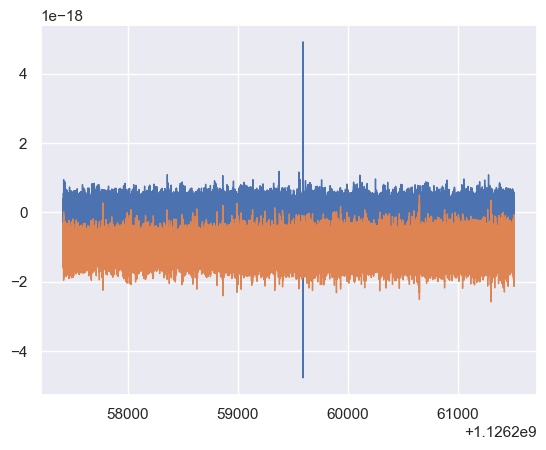

In [14]:
plt.plot(time_H1, strain_H1, linewidth=1)
plt.plot(time_L1, strain_L1, linewidth=1)

In [15]:
time = time_H1
indxt_around = np.where((time >= time_center - 512) & (time < time_center + 512))

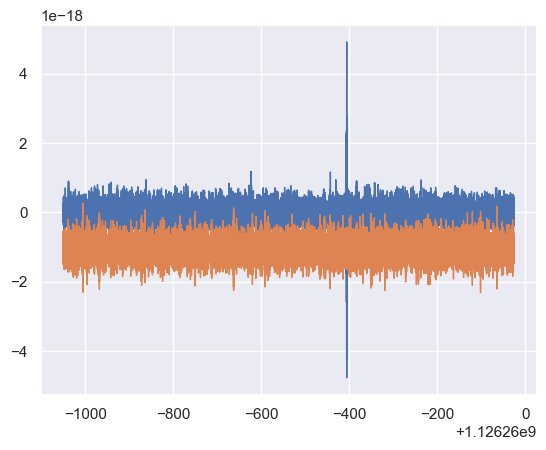

In [16]:
plt.plot(time_H1[indxt_around], strain_H1[indxt_around], linewidth=1)
plt.plot(time_L1[indxt_around], strain_L1[indxt_around], linewidth=1)

# $\textit{Elegimos la ventana}$

In [17]:
from numpy.fft import fft
from numpy.fft import fftshift

In [306]:
N = 64
n = np.linspace(0,N-1,N)

SquareW = [1]*N #Square window
TriangW = N/2 - np.abs(n-(N-1)/2) #Triangular window
HanW = 0.5 - 0.5 * np.cos((2*np.pi*n)/(N-1)) #Hanning window
HamW = 0.54 - 0.46 * np.cos((2*np.pi*n)/(N-1)) #Hamming window
BlkHarrW = 0.36 - 0.49 * np.cos((2*np.pi*n)/(N-1)) + 0.14 * np.cos((4*np.pi*n)/(N-1)) - 0.012 * np.cos((6*np.pi*n)/(N-1)) #Blackman-Nuttall

currWindow = SquareW #Choose window

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_3664\1601925446.py:8: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))


(-120.0, 1.0)

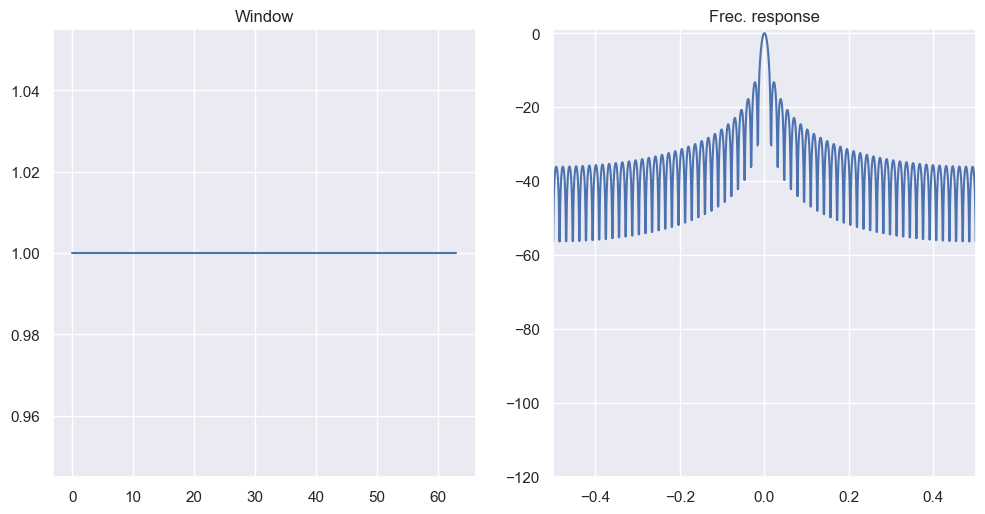

In [307]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0)
fig.set_figwidth(10)

A = fft(currWindow, 2048) / (N/2.0)
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))

axs[0].set_title("Window")
axs[0].plot(currWindow)

axs[1].set_title("Frec. response")
axs[1].plot(freq, response)
axs[1].set_xlim([-0.5, 0.5])
axs[1].set_ylim([-120, 1])

# $\textit{Agarramos ventanas de datos de tamaño L}$

In [161]:
after = np.max(indxt_around)
before = np.min(indxt_around)
L = 64

#Getting an neighbourhood of the event
strain_H1_after_noise = strain_H1[:after]
strain_L1_after_noise = strain_L1[:after]
strain_H1_before_noise = strain_H1[before:]
strain_L1_before_noise = strain_L1[before:]

getChunckForward = lambda lst: [lst[i:i + L] for i in range(0, len(lst), L)][:-1]
getChunckDownward = lambda lst: [lst[len(lst)-L-i:len(lst)-i] for i in range(0, len(lst), L)]

#Chequear el tama;o de los chuncks para getChunckDownward

noiseH1After = getChunckForward(strain_H1_after_noise)
noiseL1After = getChunckForward(strain_L1_after_noise)
noiseH1Before = getChunckDownward(strain_H1_before_noise)
noiseL1Before = getChunckDownward(strain_L1_before_noise)

In [162]:
len(noiseH1After[0])

64

In [163]:
len(noiseH1Before[len(noiseH1Before)-1])

64

# $\textit{Calculamos la PSD}$

In [164]:
def estimateAutocorrelation(seq):
    
    N = len(seq)
    rx = np.zeros(N)
    
    for l in range(N):
        acc = 0
        for n in range(N-l):
            acc += (seq[n+l]) * np.conjugate(seq[n])
        rx[l] = acc / N
    
    return rx


In [188]:
def PSD(seq):
    rv = estimateAutocorrelation(seq)
    rx = fft(rv, 2048) / (N/2.0)
    Rx = np.abs(fftshift(rx)) 
    return Rx

In [308]:
exampleSize = 500
PSDs = [PSD(currWindow * noiseH1After[i]) for i in range(len(noiseH1After))[:exampleSize]]

# $\textit{Periodogram}$

Text(0.5, 1.0, 'Periodogram')

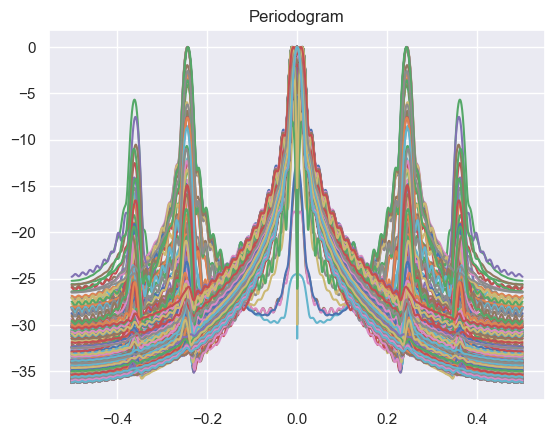

In [309]:
for i in range(len(PSDs)):
    A = PSDs[i]
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs((A / abs(A).max())))
    plt.plot(freq, response)
plt.title("Periodogram")

# $\textit{Periodogram Smoothing}$

Text(0.5, 1.0, 'Periodogram smoothing')

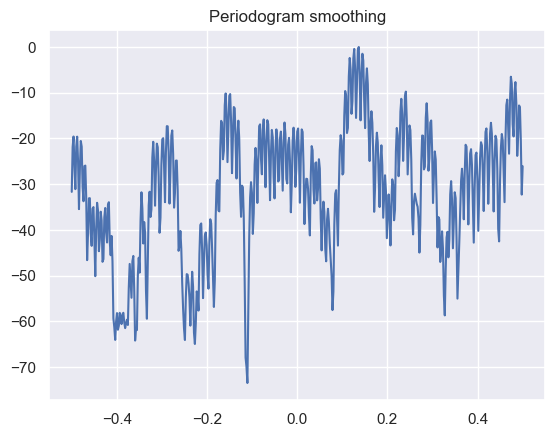

In [310]:
M = 1

A = []

for i in range(M, len(PeriodAv)-M+1):
    #Aca hay un tema de desfasaje ademas de ue esta re mal
    curr = np.sum(PSDs[:][i-M:i+M], axis=0)[(2*M+1)//2]
    A.append(curr)
A = np.divide(A, 2*M+1)

freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs((A / abs(A).max())))
plt.plot(freq, response)
plt.title("Periodogram smoothing")

# $\textit{Periodogram Averaging}$

Text(0.5, 1.0, 'Periodogram averaging')

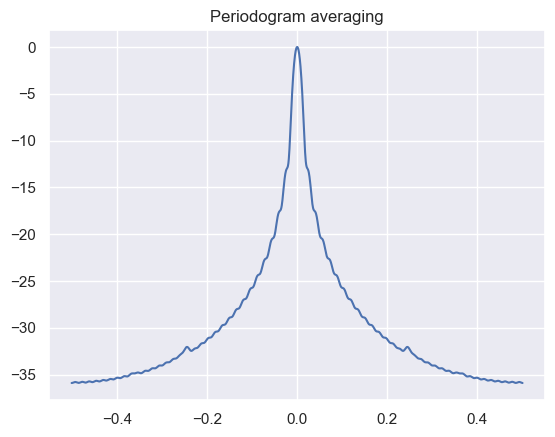

In [311]:
A = np.sum(PSDs, axis=0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs((A / abs(A).max())))
plt.plot(freq, response)
plt.title("Periodogram averaging")